In [8]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from collections import Counter

In [ ]:
# Step 1: Load and prepare dataset
data_dir = "Brain_Cancer"
class_names = os.listdir(data_dir)
class_names.sort()
print("Classes:", class_names)

image_paths = []
labels = []

for idx, cls in enumerate(class_names):
    cls_folder = os.path.join(data_dir, cls)
    for file in os.listdir(cls_folder):
        if file.endswith(".jpg") or file.endswith(".png"):
            image_paths.append(os.path.join(cls_folder, file))
            labels.append(idx)

Classes: ['brain_glioma', 'brain_menin', 'brain_tumor']


In [ ]:
# Step 2: Train-test split
train_paths, test_paths, train_labels, test_labels = train_test_split(
    image_paths, labels, test_size=0.2, random_state=42, stratify=labels
)

In [ ]:
# Step 3: Preprocessing functions
IMG_SIZE = 128
BATCH_SIZE = 32

def process_image(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_image(image, channels=3, expand_animations=False)
    image.set_shape([None, None, 3])  # Important!
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = image / 255.0
    return image, label

train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
train_ds = train_ds.map(process_image).shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((test_paths, test_labels))
test_ds = test_ds.map(process_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


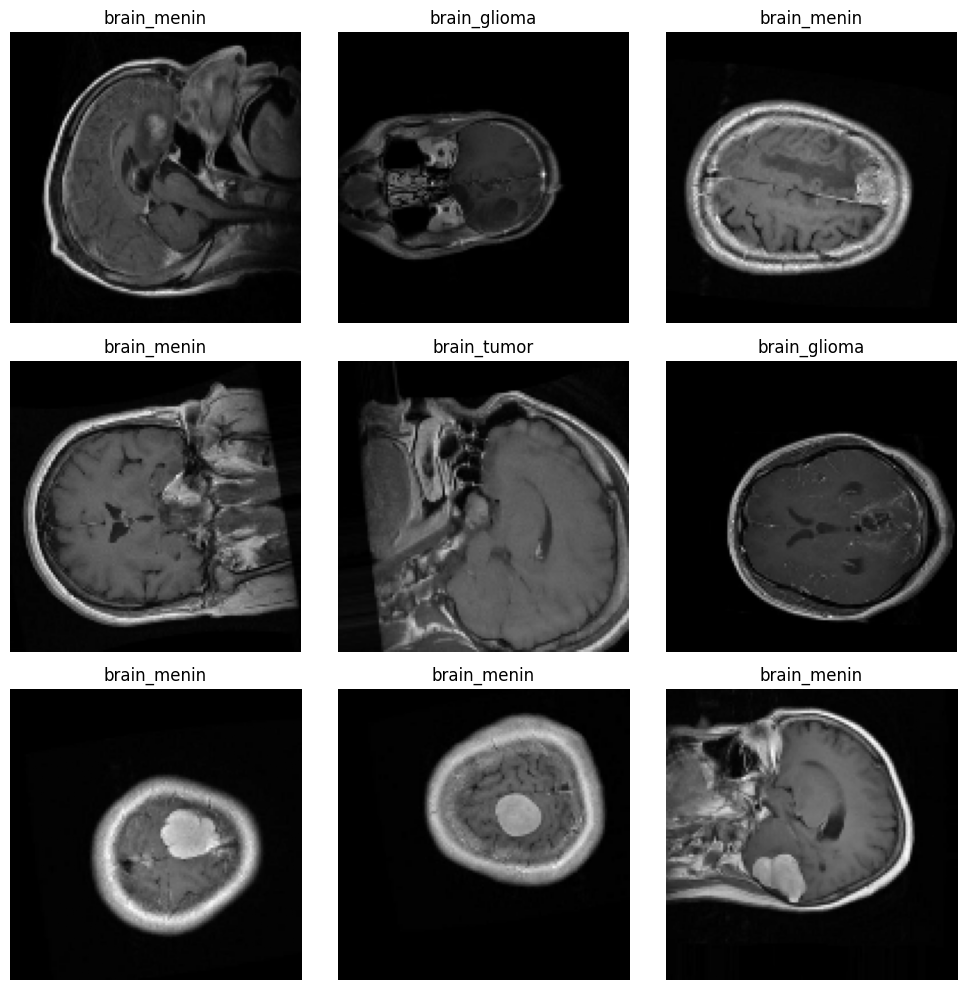

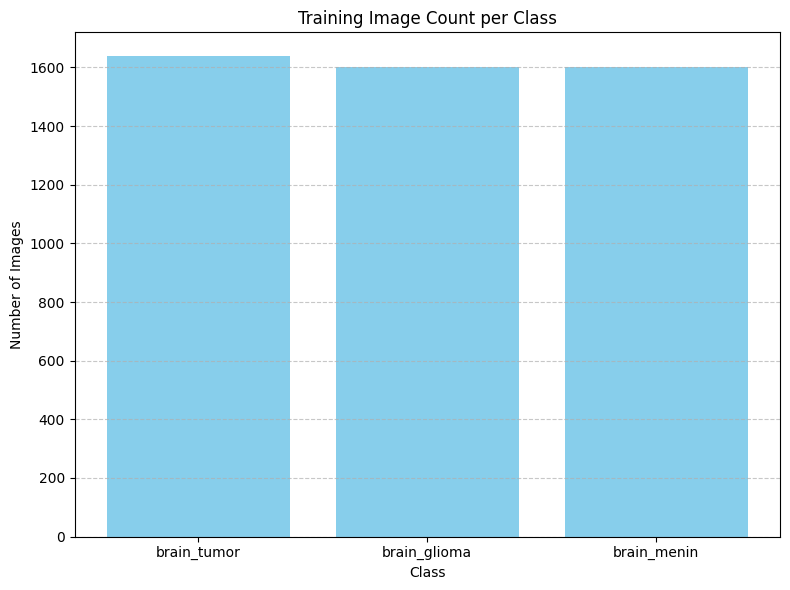

In [ ]:
# Step 4: EDA
def show_samples(dataset, class_names):
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i+1)
            plt.imshow(images[i])
            plt.title(class_names[labels[i].numpy()])
            plt.axis("off")
    plt.tight_layout()
    plt.show()

show_samples(train_ds, class_names)


# Count images per class
train_class_counts = Counter(train_labels)

# Extract class names and counts
class_labels = [class_names[cls_idx] for cls_idx in train_class_counts.keys()]
image_counts = list(train_class_counts.values())

# Plot
plt.figure(figsize=(8, 6))
plt.bar(class_labels, image_counts, color='skyblue')
plt.title('Training Image Count per Class')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
# Step 5: CNN Model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(128, 3, activation='relu'),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(len(class_names), activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,699 (397.26 KB)

 Trainable params: 101,699 (397.26 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Step 6: Train model
history = model.fit(train_ds, validation_data=test_ds, epochs=10)

Epoch 1/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 96s 600ms/step - accuracy: 0.5069 - loss: 0.9350 - val_accuracy: 0.6675 - val_loss: 0.7244
Epoch 2/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 73s 475ms/step - accuracy: 0.6560 - loss: 0.7281 - val_accuracy: 0.6807 - val_loss: 0.7057
Epoch 3/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 73s 472ms/step - accuracy: 0.6671 - loss: 0.7063 - val_accuracy: 0.6856 - val_loss: 0.6892
Epoch 4/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 72s 468ms/step - accuracy: 0.6768 - loss: 0.6887 - val_accuracy: 0.6733 - val_loss: 0.7268
Epoch 5/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 72s 467ms/step - accuracy: 0.7038 - loss: 0.6552 - val_accuracy: 0.7096 - val_loss: 0.6302
Epoch 6/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 73s 469ms/step - accuracy: 0.7256 - loss: 0.6184 - val_accuracy: 0.7483 - val_loss: 0.5819
Epoch 7/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 72s 467ms/step - accuracy: 0.7438 - loss: 0.5843 - val_accuracy: 0.7698 - val_loss: 0.5525
Epoch 8/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 71s 461ms/step - accuracy: 0.7560 - loss: 0

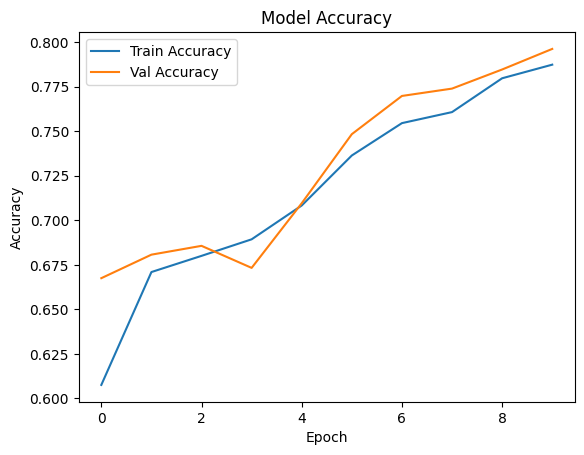

In [ ]:
# Step 7: Evaluation
# Accuracy plot
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

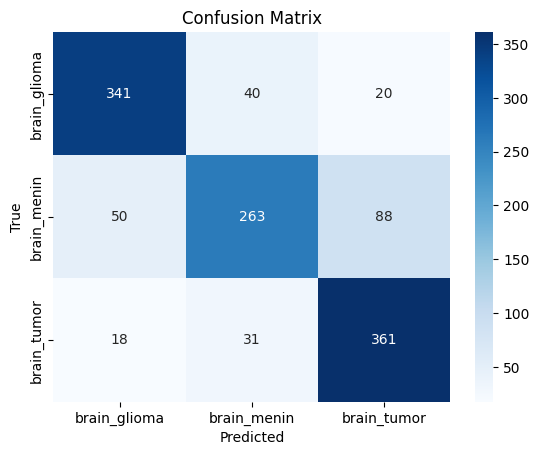

In [15]:
# Classification report
y_pred = []
y_true = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(labels.numpy())

print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

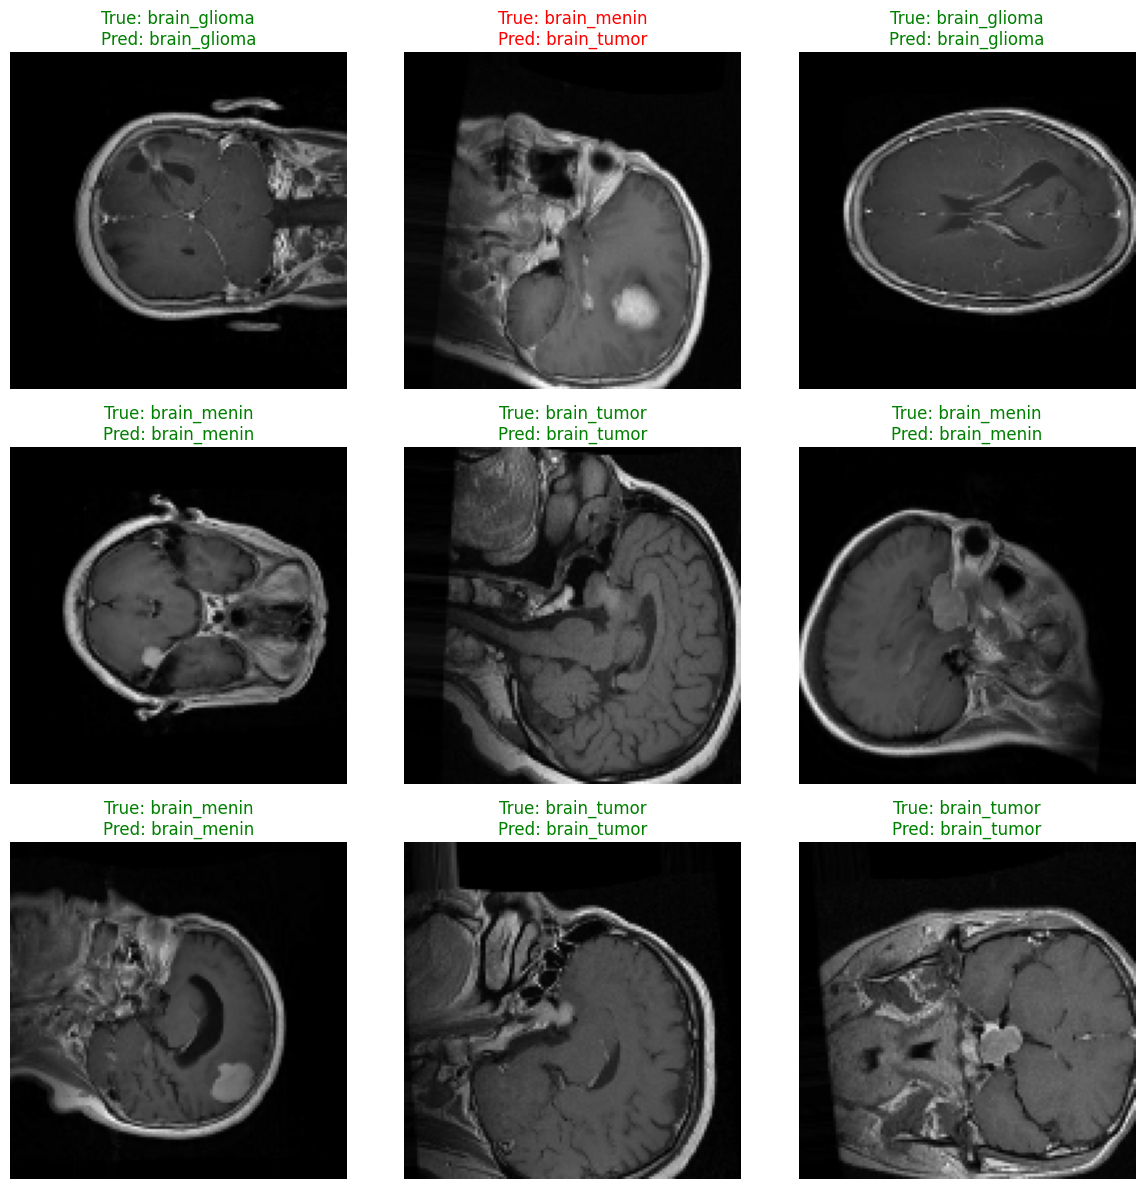

In [ ]:
# Step 8: Predicted Imagess

# Convert lists to numpy arrays
y_pred = np.array(y_pred)
y_true = np.array(y_true)

# Create a dataset iterator for test images
test_images = []
for images, _ in test_ds:
    test_images.extend(images.numpy())

# Display first 9 test images with predictions
plt.figure(figsize=(12, 12))
for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(test_images[i])
    true_label = class_names[y_true[i]]
    pred_label = class_names[y_pred[i]]
    color = "green" if true_label == pred_label else "red"
    plt.title(f"True: {true_label}\nPred: {pred_label}", color=color)
    plt.axis("off")
plt.tight_layout()
plt.show()
